<a href="https://colab.research.google.com/github/ravishanilneth/Early-Detection-of-Alzheimer-s-Disease-Using-Explainable-AI-Powered-Deep-Learning/blob/main/MRI_VGG16_Model%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import nibabel as nib
import cv2
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D  # Import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Define constants
IMG_SIZE = 224
SLICE_SELECTION = 'middle'
NUM_SLICES = 10
CHANNELS = 3  # For RGB images
CLASSES = ['Non Demented', 'Very Mild Dementia', 'Mild Dementia', 'Moderate Dementia']
TARGET_COUNT_PER_CLASS = 1000

# Load and preprocess a NIfTI image
def load_nifti_image(file_path):
    img = nib.load(file_path)
    img_data = img.get_fdata()
    img_data = (img_data - np.min(img_data)) / (np.max(img_data) - np.min(img_data))

    if SLICE_SELECTION == 'middle':
        slice_index = img_data.shape[2] // 2
        img_slice = img_data[:, :, slice_index]
        img_slice = cv2.resize(img_slice, (IMG_SIZE, IMG_SIZE))
        img_slice_rgb = np.stack((img_slice,) * 3, axis=-1)
        return img_slice_rgb
    elif SLICE_SELECTION == 'custom':
        slices = []
        indices = np.linspace(0, img_data.shape[2] - 1, NUM_SLICES).astype(int)
        for i in indices:
            img_slice = cv2.resize(img_data[:, :, i], (IMG_SIZE, IMG_SIZE))
            img_slice_rgb = np.stack((img_slice,) * 3, axis=-1)
            slices.append(img_slice_rgb)
        return np.array(slices)

# Image augmentation
def augment_images_per_class(main_dir, classes, target_count_per_class):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    images, labels = [], []
    for label, class_name in enumerate(classes):
        class_dir = os.path.join(main_dir, class_name)
        current_count = 0

        for patient_folder in os.listdir(class_dir):
            patient_dir = os.path.join(class_dir, patient_folder)
            if not os.path.isdir(patient_dir):
                continue
            nifti_files = [os.path.join(patient_dir, f) for f in os.listdir(patient_dir)
                           if f.endswith('.nii') or f.endswith('.nii.gz')]

            for file_path in nifti_files:
                img = load_nifti_image(file_path)
                images.append(img)
                labels.append(label)
                current_count += 1

                # Perform augmentation
                aug_iter = datagen.flow(np.expand_dims(img, axis=0), batch_size=1)
                while current_count < target_count_per_class:
                    aug_img = next(aug_iter)[0]
                    images.append(aug_img)
                    labels.append(label)
                    current_count += 1

                if current_count >= target_count_per_class:
                    break

    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32)

# Directory containing the 4 Alzheimer's stages
main_dir = "D:/KDU/final year research/Alzhimer's disease early detection/SUPIRI DATASETS/final"

# Augment images before splitting
images, labels = augment_images_per_class(main_dir, CLASSES, TARGET_COUNT_PER_CLASS)

# Split the augmented dataset
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels)
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.1, random_state=42, stratify=train_labels)

In [ ]:
print("Training images:", train_images.shape)
print("Validation images:", val_images.shape)
print("Test images:", test_images.shape)

Training images: (3034, 224, 224, 3)
Validation images: (338, 224, 224, 3)
Test images: (844, 224, 224, 3)


In [ ]:
# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels, num_classes=len(CLASSES))
val_labels = to_categorical(val_labels, num_classes=len(CLASSES))
test_labels = to_categorical(test_labels, num_classes=len(CLASSES))

In [ ]:
# Compute class weights
train_labels_single = np.argmax(train_labels, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels_single), y=train_labels_single)
class_weight_dict = dict(enumerate(class_weights))

print("Class weights:", class_weights)

Class weights: [0.93990087 0.98763021 1.02777778 1.0520111 ]


In [ ]:
# Build the model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
predictions = Dense(len(CLASSES), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Apply L2 regularization to the convolutional layers in the VGG16 model
for layer in base_model.layers:
    if isinstance(layer, Conv2D):
        layer.kernel_regularizer = l2(0.002)

# Freeze layers
for layer in base_model.layers[:-3]:
    layer.trainable = False

# Compile the model
from tensorflow.keras.metrics import Precision, Recall, AUC

# Compile the model with additional metrics
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)

In [ ]:
# Set up callbacks
checkpoint = ModelCheckpoint('best_model_final_version_2_1.h5', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', restore_best_weights=True)
callbacks = [checkpoint, early_stopping]

In [ ]:
# Train the model
history = model.fit(
    train_images, train_labels, batch_size=32,
    epochs=5,
    validation_data=(val_images, val_labels),
    class_weight=class_weight_dict,
    callbacks=callbacks
)

Epoch 1/5
95/95 [==============================] - 448s 4s/step - loss: 0.0981 - accuracy: 0.9677 - precision: 0.9760 - recall: 0.9631 - auc: 0.9977 - val_loss: 0.7896 - val_accuracy: 0.7574 - val_precision: 1.0000 - val_recall: 0.5888 - val_auc: 0.9486
Epoch 2/5
95/95 [==============================] - 428s 5s/step - loss: 0.0347 - accuracy: 0.9855 - precision: 0.9871 - recall: 0.9838 - auc: 0.9996 - val_loss: 0.4998 - val_accuracy: 0.9704 - val_precision: 0.9934 - val_recall: 0.8905 - val_auc: 0.9933
Epoch 3/5
95/95 [==============================] - 437s 5s/step - loss: 0.0284 - accuracy: 0.9895 - precision: 0.9898 - recall: 0.9895 - auc: 0.9996 - val_loss: 0.1920 - val_accuracy: 0.9763 - val_precision: 0.9849 - val_recall: 0.9675 - val_auc: 0.9966
Epoch 4/5
95/95 [==============================] - 439s 5s/step - loss: 0.0113 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9957 - auc: 1.0000 - val_loss: 0.1451 - val_accuracy: 0.9704 - val_precision: 0.9731 - val_recall: 0.9645 - 

In [ ]:
# Evaluate the model and capture all metric outputs
evaluation_results = model.evaluate(test_images, test_labels)

# Unpack the results based on the number of metrics defined in model.compile
loss, accuracy, precision, recall, auc = evaluation_results
print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test AUC: {auc:.4f}')

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
print(f'Test F1 Score: {f1_score:.4f}')

27/27 [==============================] - 74s 3s/step - loss: 0.0987 - accuracy: 0.9692 - precision: 0.9703 - recall: 0.9680 - auc: 0.9969
Test Accuracy: 96.92%
Test Precision: 0.9703
Test Recall: 0.9680
Test AUC: 0.9969
Test F1 Score: 0.9692


In [ ]:
a# Predict and evaluate metrics
predicted_labels = model.predict(test_images)
predicted_labels = np.argmax(predicted_labels, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

27/27 [==============================] - 80s 3s/step

Confusion Matrix:
[[211  12   2   0]
 [  8 206   0   0]
 [  0   4 201   0]
 [  0   0   0 200]]


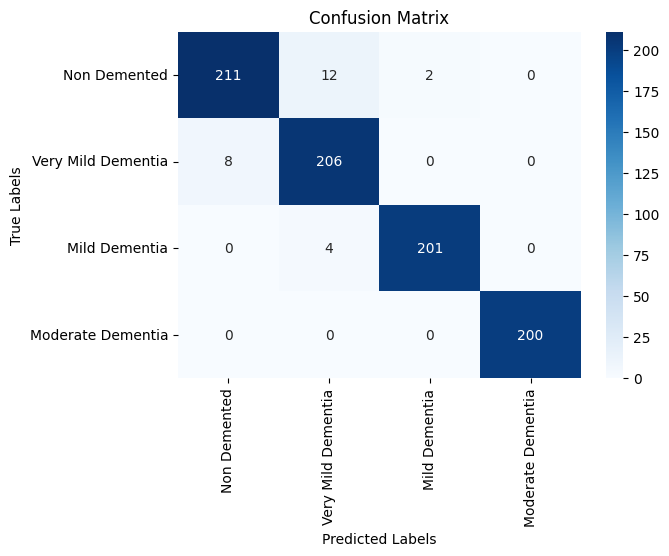

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(6.5, 4.5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

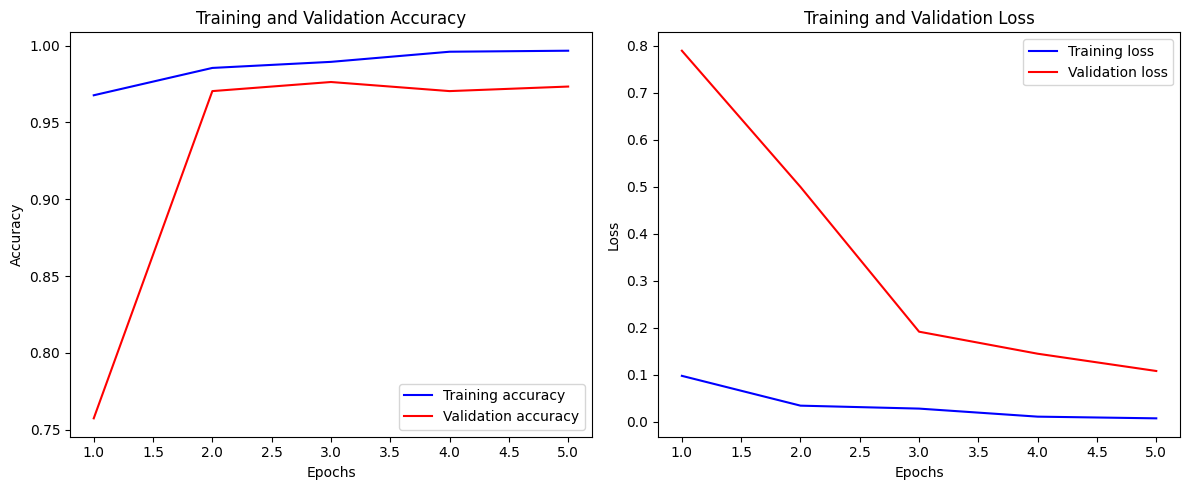

In [ ]:
# Plot learning curves
def plot_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

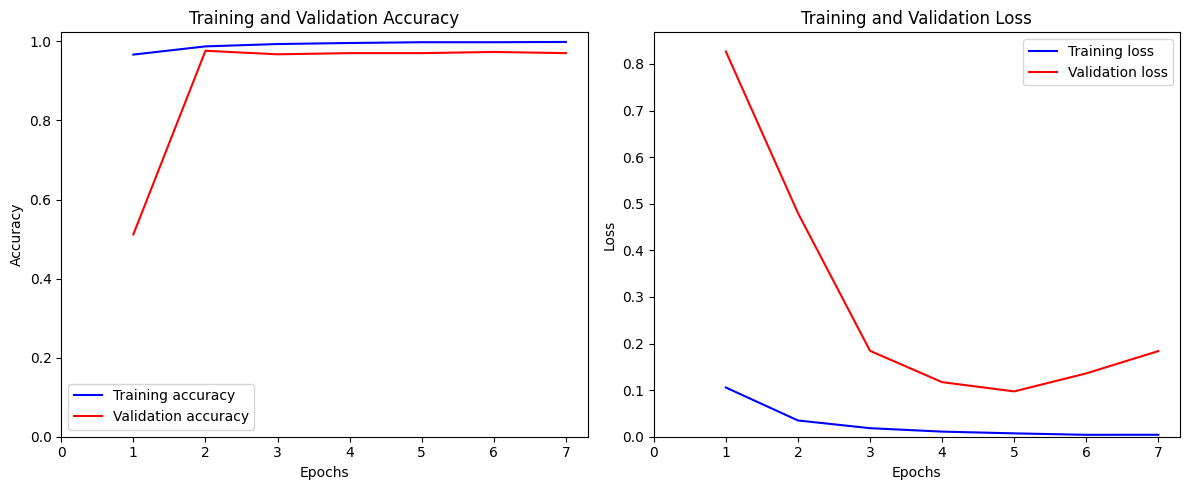

In [ ]:
# Plot learning curves with consistent scaling
def plot_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))

    # Set consistent y-axis range for accuracy and loss
    y_max = max(max(acc), max(val_acc), max(loss), max(val_loss))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim(0, )  # Start y-axis from 0 and set consistent max limit
    plt.xlim(0, )  # Start x-axis from 0

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.ylim(0, )  # Start y-axis from 0 and set consistent max limit
    plt.xlim(0, )  # Start x-axis from 0

    plt.tight_layout()
    plt.show()

# Call the function with the history object
plot_learning_curves(history)

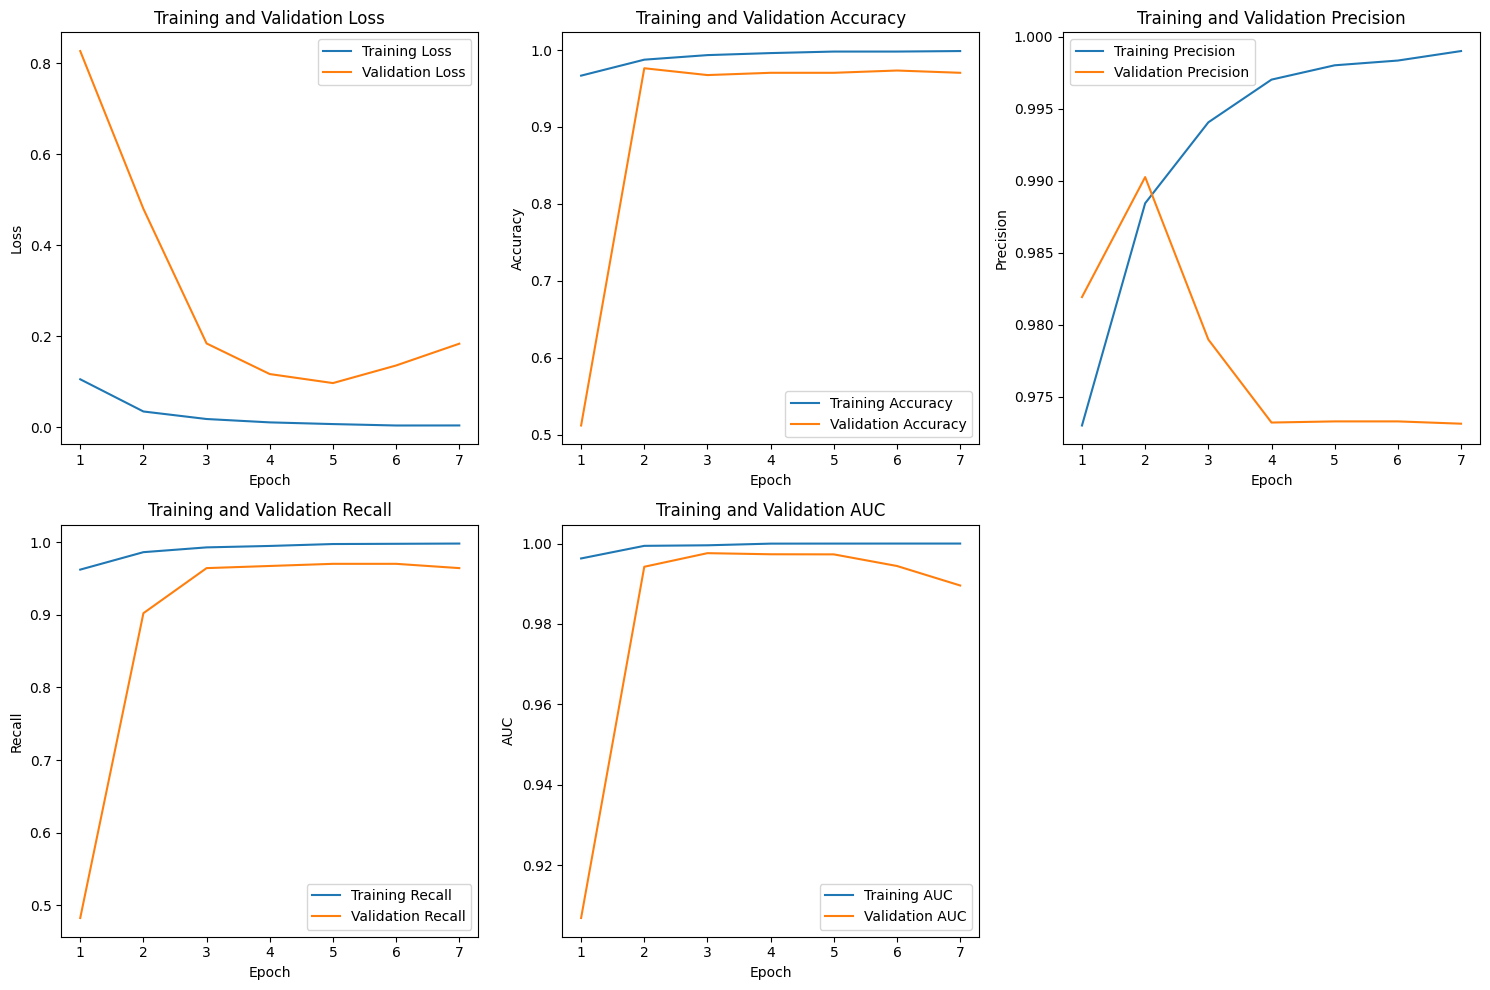

In [ ]:
# Extract metrics from the training history
epochs = range(1, len(history.history['loss']) + 1)

# Plotting training & validation loss values
plt.figure(figsize=(15, 10))

# Loss plot
plt.subplot(2, 3, 1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(2, 3, 2)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision plot
plt.subplot(2, 3, 3)
plt.plot(epochs, history.history['precision'], label='Training Precision')
plt.plot(epochs, history.history['val_precision'], label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall plot
plt.subplot(2, 3, 4)
plt.plot(epochs, history.history['recall'], label='Training Recall')
plt.plot(epochs, history.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC plot
plt.subplot(2, 3, 5)
plt.plot(epochs, history.history['auc'], label='Training AUC')
plt.plot(epochs, history.history['val_auc'], label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()
